# TP N°4 : Les Réseaux de Neurones Récurrents

## Travail fait par : Yasmine Gharbi et Arij Habbechi RT4/1

### **Objectif :**
Ce TP a pour objectif d’appliquer trois types différents de réseaux de neurones profonds sur un
ensemble de données du monde réel. Nous utiliserons le réseau de neurones à connexion dense
(réseau de neurones de base), le réseau de neurones convolutionnel (CNN) et le réseau de
mémoire à long court terme (LSTM), qui est une variante des réseaux de neurones récurrents.

Nous allons utiliser Keras Embedding Layer et GloVe comme word embedding pour convertir
le texte en forme numérique.

## Importation des bibliothèques :

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
from keras.layers import GRU

## Importation du dataset :

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Import IMDB dataset using pandas read_csv method
imdb_df = pd.read_csv('/content/drive/My Drive/IMDB Dataset.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dimension of the dataset
print("Dimension of the dataset:", imdb_df.shape)

Dimension of the dataset: (50000, 2)


In [ ]:
# Check for NULL values
print("Contains NULL values:", imdb_df.isnull().values.any())


Contains NULL values: False


In [ ]:
# Display the first 5 rows
print("First 5 rows of the dataset:")
print(imdb_df.head())

First 5 rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


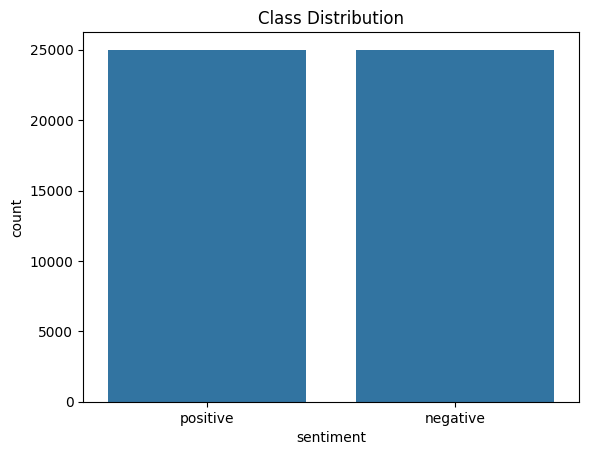

In [ ]:
# Use countplot from seaborn to visualize class balance
sns.countplot(x='sentiment', data=imdb_df)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Display the 4th review
print("4th review:")
print(imdb_df['review'][3])

4th review:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


Que remarquez-vous ?

although we can conclude that the writer's opinion of the film was negative, the review itself had mixed sentiments and required longer clarification and may not be easy to draw a conclusion from it

## Prétraitement de données :

In [ ]:
def preprocess_text(sen):
  # Removing html tags
  sentence = remove_tags(sen)
  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  return sentence

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(imdb_df['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

In [ ]:
# Display the 4th review
print("4th review:")
print(X[3])

4th review:
Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them 


Que remarquez-vous ?

without the punctuation, the meaning of the sentences could be lost.

Nous devons convertir nos étiquettes en chiffres. Puisque nous n'avons que deux
étiquettes dans la sortie, à savoir "positive" et "négative". Nous pouvons simplement les
convertir en nombres entiers en remplaçant "positif" par le chiffre 1 et négatif par le
chiffre 0 comme indiqué ci-dessous :

In [ ]:
y = imdb_df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Diviser le dataset en training et test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

## La couche de l’embedding

Dans un premier temps, nous allons utiliser la classe Tokenizer du module
keras.preprocessing.text pour créer un dictionnaire word-to-index. Dans le
dictionnaire word-to-index, chaque mot du corpus est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train contient 40000 listes correspondant aux phrases où chacune contient des entiers.
La taille de chaque liste est différente car les phrases possèdent des tailles différentes.
Le script ci-dessous trouve la taille du vocabulaire, puis effectue un remplissage sur
l'ensemble d'entraînement et de test.

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Les listes ont la même longueur, c'est-à-dire 100. De plus, la variable vocabulary_size
contient maintenant une valeur 92547, ce qui signifie que le corpus contient 92547 mots
uniques.

Nous utiliserons GloVe pour créer notre matrice de features. Dans le script suivant, nous
chargeons GloVe et créons un dictionnaire qui contiendra des mots en tant que clés et
leur liste d’embeddings correspondante en tant que valeurs.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from google.colab import drive


# Path to the GloVe file in drive
glove_path = "/content/drive/My Drive/glove.6B.100d.txt"

# Load GloVe embeddings
embeddings_dictionary = dict()
with open(glove_path, encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()


Enfin, nous allons créer une matrice d’embeddings où chaque numéro de ligne
correspondra à l'index du mot dans le corpus. La matrice aura 100 colonnes où chaque
colonne contiendra les embeddings GloVe pour les mots de notre corpus.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():

  if index < vocab_size:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

## A. Classification avec un simple réseau de neurones

In [ ]:
embedding_matrix.shape

(10000, 100)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Define model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Add Flatten layer
model.add(Flatten())

# Add Dense layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Fit model
epochs = 6
batch_size = 128
verbose = 1
validation_split = 0.2
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split)


Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6113 - acc: 0.6652 - val_loss: 0.5455 - val_acc: 0.7222
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4996 - acc: 0.7613 - val_loss: 0.5230 - val_acc: 0.7445
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4623 - acc: 0.7829 - val_loss: 0.5374 - val_acc: 0.7301
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.4362 - acc: 0.8003 - val_loss: 0.5251 - val_acc: 0.7411
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4234 - acc: 0.8059 - val_loss: 0.5468 - val_acc: 0.7343
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4108 - acc: 0.8146 - val_loss: 0.5419 - val_acc: 0.7396


Évaluer le modèle en utilisant la méthode evaluate qui renvoie les scores de
« loss » et « accuracy »

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5334 - acc: 0.7418
Test Score: 0.53336501121521
Test Accuracy: 0.7418000102043152


Essayons de tracer les fonctions de loss et de accuracy pour les training et test sets.
Que remarquez-vous ?

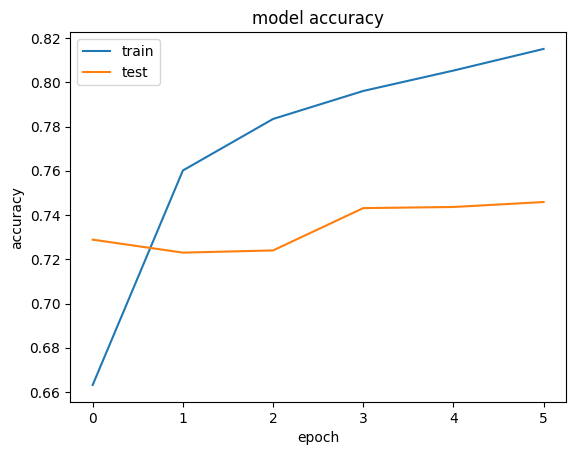

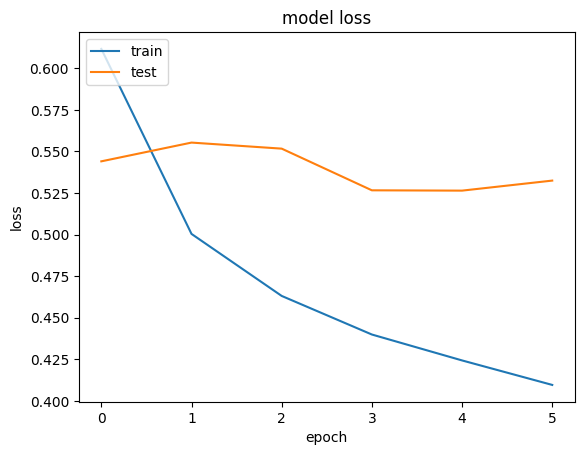

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## B. Classification avec un réseau de neurones convolutionnel

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam

# Définir le modèle séquentiel
model = Sequential()

# Ajouter la couche d'Embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length= maxlen))

# Ajouter la couche Conv1D
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Ajouter la couche de MaxPooling1D
model.add(MaxPooling1D())

# Aplatir les données pour les couches fully connected
model.add(Flatten())

# Ajouter la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Résumé du modèle
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9254700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6145      
                                                                 
Total params: 9324973 (35.57 MB)
Trainable params: 9324973 (35.57 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [ ]:
history2 = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split)

Epoch 1/6
250/250 [==============================] - 91s 359ms/step - loss: 0.5316 - acc: 0.7190 - val_loss: 0.3757 - val_acc: 0.8346
Epoch 2/6
250/250 [==============================] - 86s 344ms/step - loss: 0.3287 - acc: 0.8574 - val_loss: 0.3443 - val_acc: 0.8524
Epoch 3/6
250/250 [==============================] - 87s 347ms/step - loss: 0.2568 - acc: 0.8935 - val_loss: 0.3238 - val_acc: 0.8620
Epoch 4/6
250/250 [==============================] - 89s 356ms/step - loss: 0.1963 - acc: 0.9248 - val_loss: 0.3743 - val_acc: 0.8431
Epoch 5/6
250/250 [==============================] - 88s 354ms/step - loss: 0.1341 - acc: 0.9558 - val_loss: 0.3694 - val_acc: 0.8581
Epoch 6/6
250/250 [==============================] - 86s 346ms/step - loss: 0.0725 - acc: 0.9834 - val_loss: 0.4141 - val_acc: 0.8495


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 4s 12ms/step - loss: 0.3942 - acc: 0.8551
Test Score: 0.39416268467903137
Test Accuracy: 0.8550999760627747


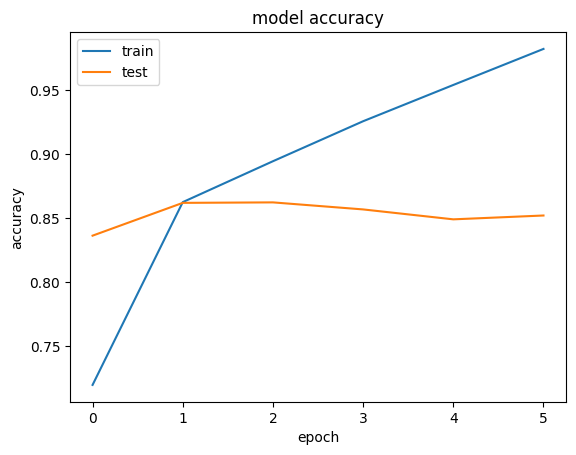

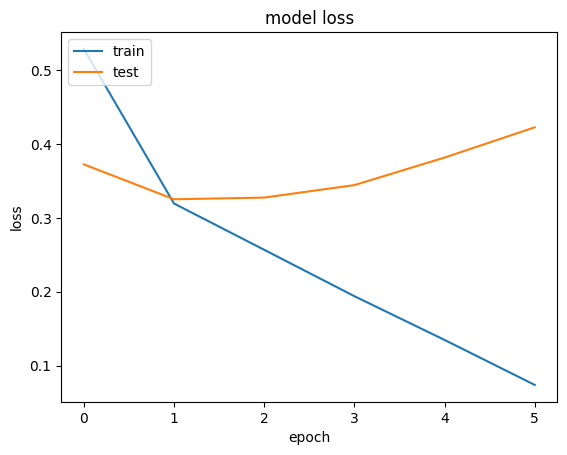

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## C. Classification avec un réseau de neurones récurrent (LSTM)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam

# Définir le modèle séquentiel
model = Sequential()

# Ajouter la couche d'Embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

# Ajouter la couche LSTM
model.add(LSTM(units=128))

# Ajouter la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Résumé du modèle
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9254700   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9372077 (35.75 MB)
Trainable params: 9372077 (35.75 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 6
batch_size = 128
verbose = 1
validation_split = 0.2

In [ ]:
history3 = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=validation_split)

Epoch 1/6
250/250 [==============================] - 31s 109ms/step - loss: 0.4848 - acc: 0.7588 - val_loss: 0.3600 - val_acc: 0.8407
Epoch 2/6
250/250 [==============================] - 9s 35ms/step - loss: 0.3274 - acc: 0.8594 - val_loss: 0.3603 - val_acc: 0.8516
Epoch 3/6
250/250 [==============================] - 7s 26ms/step - loss: 0.2848 - acc: 0.8819 - val_loss: 0.3351 - val_acc: 0.8649
Epoch 4/6
250/250 [==============================] - 5s 18ms/step - loss: 0.2553 - acc: 0.8977 - val_loss: 0.3269 - val_acc: 0.8648
Epoch 5/6
250/250 [==============================] - 4s 16ms/step - loss: 0.2334 - acc: 0.9089 - val_loss: 0.3391 - val_acc: 0.8651
Epoch 6/6
250/250 [==============================] - 5s 19ms/step - loss: 0.2103 - acc: 0.9193 - val_loss: 0.3503 - val_acc: 0.8629


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.3305 - acc: 0.8730
Test Score: 0.330457866191864
Test Accuracy: 0.8730000257492065


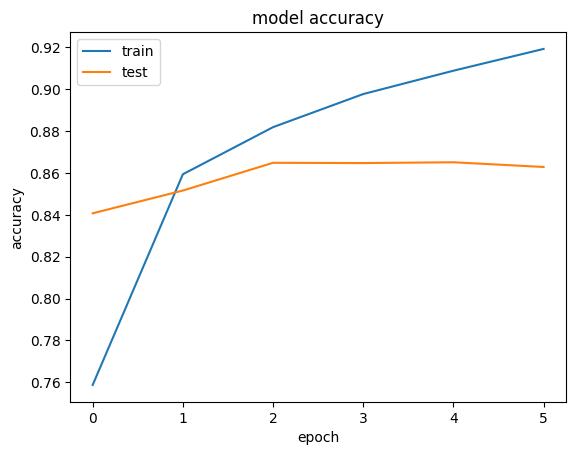

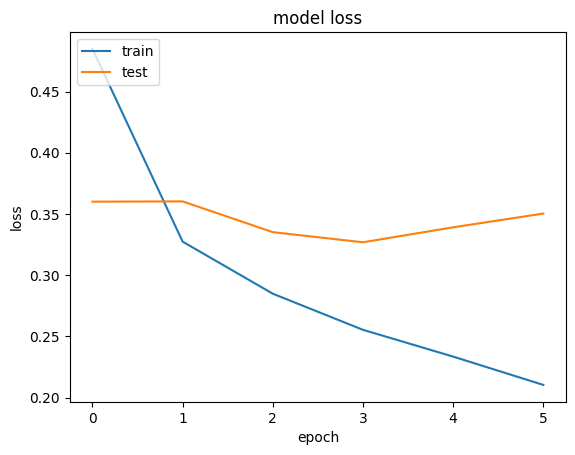

In [ ]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
random_review=X_test[2598]
random_review.shape


(100,)

In [ ]:
random_review.reshape(1,-1).shape

(1, 100)

In [ ]:
pred=model.predict(random_review.reshape(1,-1))

1/1 [==============================] - 0s 405ms/step


In [ ]:
if pred >= 0.5:
    predicted_class = 1  # Positive class
else:
    predicted_class = 0  # Negative class

print("predicted class is: ", predicted_class, " actual class is: ", y_test[2598])

predicted class is:  1  actual class is:  1


## **Compte rendu :**

in this part, we will fill the table with accuracy results for the test set for different models with different embeddings methods :     

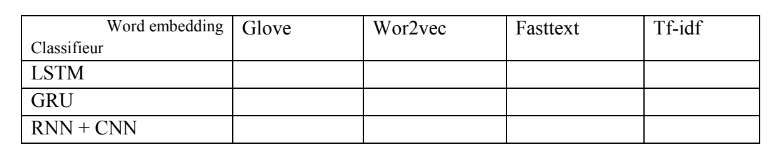

In [ ]:
def evaluate_mode(X_test, y_test, model):
  score = model.evaluate(X_test, y_test, verbose=1)
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

In [ ]:
def plot_accur_loss(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()


### **1- Glove :**

Au cours de premier partie du TP on a testé la methode Glove avec LSTM et maintenant on implement le modele "GRU" et "LSTM + CNN"

**GRU model** :

In [ ]:
gru_model=Sequential()

gru_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False))

gru_model.add(GRU(128))

gru_model.add(Dense(1,activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history_gru =gru_model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 11ms/step - loss: 0.5254 - accuracy: 0.7206 - val_loss: 0.4422 - val_accuracy: 0.7969
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3952 - accuracy: 0.8204 - val_loss: 0.3888 - val_accuracy: 0.8206
Epoch 3/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3588 - accuracy: 0.8417 - val_loss: 0.3521 - val_accuracy: 0.8455
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3364 - accuracy: 0.8516 - val_loss: 0.3335 - val_accuracy: 0.8521
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3152 - accuracy: 0.8641 - val_loss: 0.3540 - val_accuracy: 0.8405
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2943 - accuracy: 0.8731 - val_loss: 0.3300 - val_accuracy: 0.8547


In [ ]:
evaluate_mode(X_test, y_test, gru_model)

313/313 [==============================] - 2s 6ms/step - loss: 0.3216 - accuracy: 0.8587
Test Score: 0.32156190276145935
Test Accuracy: 0.8586999773979187


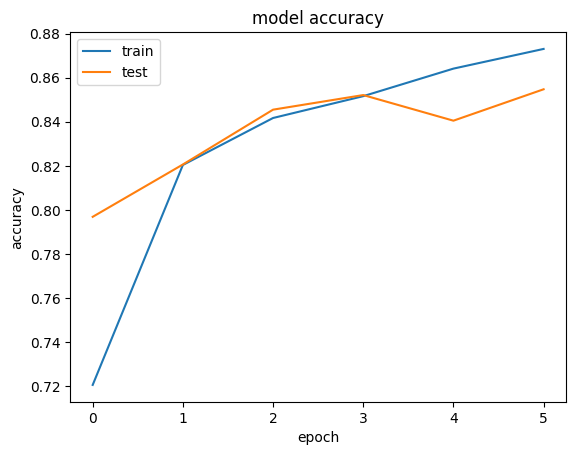

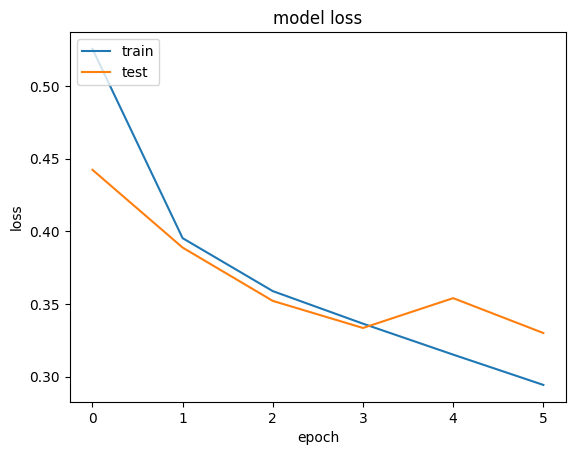

In [ ]:
plot_accur_loss(history_gru)

**LSTM+CNN model** :

In [ ]:
from keras.layers import MaxPooling1D

cnn_lstm_model=Sequential()

cnn_lstm_model.add(Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False))

cnn_lstm_model.add(Conv1D(128,5,activation='relu'))

cnn_lstm_model.add(MaxPooling1D())

cnn_lstm_model.add(LSTM(128))

cnn_lstm_model.add(Dense(1,activation='sigmoid'))

cnn_lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

cnn_lstm_history=cnn_lstm_model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 10ms/step - loss: 0.5402 - accuracy: 0.7169 - val_loss: 0.4486 - val_accuracy: 0.7971
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.4030 - accuracy: 0.8158 - val_loss: 0.3711 - val_accuracy: 0.8353
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.3548 - accuracy: 0.8443 - val_loss: 0.3616 - val_accuracy: 0.8350
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3065 - accuracy: 0.8686 - val_loss: 0.3541 - val_accuracy: 0.8416
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2736 - accuracy: 0.8880 - val_loss: 0.3779 - val_accuracy: 0.8370
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.2273 - accuracy: 0.9091 - val_loss: 0.3663 - val_accuracy: 0.8447


In [ ]:
evaluate_mode(X_test, y_test, cnn_lstm_model)

313/313 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8494
Test Score: 0.35460981726646423
Test Accuracy: 0.849399983882904


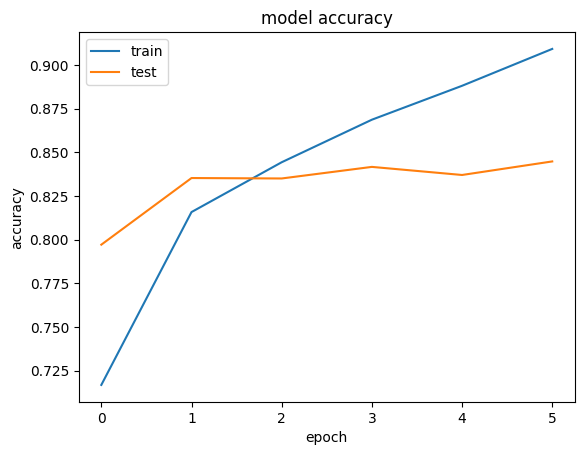

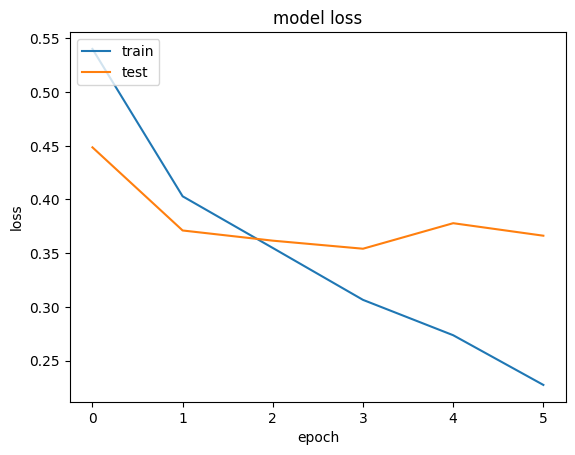

In [ ]:
plot_accur_loss(cnn_lstm_history)

### **2- Wor2vec :**

 The model contains 300-dimensional vectors for 3 million words and phrases.

In [ ]:
!wget https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz

--2024-05-07 17:54:19--  https://media.githubusercontent.com/media/eyaler/word2vec-slim/master/GoogleNews-vectors-negative300-SLIM.bin.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276467217 (264M) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300-SLIM.bin.gz’

GoogleNews-vectors- 100%[===================>] 263.66M  87.7MB/s    in 3.0s    

2024-05-07 17:54:27 (87.7 MB/s) - ‘GoogleNews-vectors-negative300-SLIM.bin.gz’ saved [276467217/276467217]



In [ ]:
!gunzip /content/GoogleNews-vectors-negative300-SLIM.bin.gz

In [ ]:
from gensim.models.keyedvectors import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300-SLIM.bin', binary=True)


In [ ]:
def getVector(str):
  if str in word2vec_model:
    return word2vec_model[str]
  else:
    return None;

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  embedding_vector = getVector(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(92547, 300)

In [ ]:
def lstm_model():
  model=Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix],input_length=maxlen , trainable=False))
  model.add(LSTM(128))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
  return model

In [ ]:
def gru_model():
  model=Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix],input_length=maxlen , trainable=False))
  model.add(GRU(128))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
  return model

In [ ]:
from keras.layers import MaxPooling1D

def cnn_lstm_model():
  model=Sequential()
  model.add(Embedding(vocab_size, 300, weights=[embedding_matrix],input_length=maxlen , trainable=False))
  model.add(Conv1D(128,5,activation='relu'))
  model.add(MaxPooling1D())
  model.add(LSTM(128))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.fit(X_train,y_train,epochs=6,batch_size=128,verbose=1,validation_split=0.2)
  return model

**LSTM :**

In [ ]:
# LSTM model
lstm_model=lstm_model()

Epoch 1/6
250/250 [==============================] - 6s 13ms/step - loss: 0.5598 - accuracy: 0.7071 - val_loss: 0.4089 - val_accuracy: 0.8154
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4191 - accuracy: 0.8114 - val_loss: 0.3846 - val_accuracy: 0.8273
Epoch 3/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3964 - accuracy: 0.8201 - val_loss: 0.3812 - val_accuracy: 0.8250
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3809 - accuracy: 0.8269 - val_loss: 0.3543 - val_accuracy: 0.8420
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3677 - accuracy: 0.8351 - val_loss: 0.3425 - val_accuracy: 0.8497
Epoch 6/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3533 - accuracy: 0.8433 - val_loss: 0.3361 - val_accuracy: 0.8526


In [ ]:
evaluate_mode(X_test, y_test, lstm_model)

313/313 [==============================] - 1s 4ms/step - loss: 0.3441 - accuracy: 0.8478
Test Score: 0.34410861134529114
Test Accuracy: 0.8478000164031982


**GRU :**

In [ ]:
gru_model=gru_model()

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.5199 - accuracy: 0.7408 - val_loss: 0.4090 - val_accuracy: 0.8215
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3996 - accuracy: 0.8201 - val_loss: 0.3707 - val_accuracy: 0.8365
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3638 - accuracy: 0.8383 - val_loss: 0.3508 - val_accuracy: 0.8450
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3466 - accuracy: 0.8464 - val_loss: 0.3418 - val_accuracy: 0.8482
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3331 - accuracy: 0.8533 - val_loss: 0.3300 - val_accuracy: 0.8547
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3259 - accuracy: 0.8570 - val_loss: 0.3299 - val_accuracy: 0.8590


In [ ]:
evaluate_mode(X_test, y_test, gru_model)

313/313 [==============================] - 1s 4ms/step - loss: 0.3287 - accuracy: 0.8552
Test Score: 0.3287149965763092
Test Accuracy: 0.8551999926567078


**LSTM+CNN :**

In [ ]:
cnn_lstm_model=cnn_lstm_model()

Epoch 1/6
250/250 [==============================] - 7s 14ms/step - loss: 0.4777 - accuracy: 0.7617 - val_loss: 0.3756 - val_accuracy: 0.8374
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3572 - accuracy: 0.8430 - val_loss: 0.3355 - val_accuracy: 0.8543
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3039 - accuracy: 0.8732 - val_loss: 0.3176 - val_accuracy: 0.8654
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.2667 - accuracy: 0.8880 - val_loss: 0.3292 - val_accuracy: 0.8659
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.2141 - accuracy: 0.9155 - val_loss: 0.3375 - val_accuracy: 0.8561
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.1620 - accuracy: 0.9401 - val_loss: 0.3570 - val_accuracy: 0.8579


In [ ]:
evaluate_mode(X_test, y_test, cnn_lstm_model)

313/313 [==============================] - 2s 5ms/step - loss: 0.3445 - accuracy: 0.8608
Test Score: 0.34451791644096375
Test Accuracy: 0.86080002784729


### **3- Fasttext**

These vectors in dimension 300 were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec

--2024-05-07 18:22:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6597238061 (6.1G) [binary/octet-stream]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>]   6.14G   154MB/s    in 37s     

2024-05-07 18:22:48 (172 MB/s) - ‘wiki.en.vec’ saved [6597238061/6597238061]



In [ ]:
from tqdm import tqdm
import re, codecs

embeddings_dictionary = {}
f = codecs.open('wiki.en.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()


2519428it [06:23, 6576.17it/s]


In [ ]:
from numpy import zeros
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape==(0,):
          continue
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(92547, 300)

**LSTM :**

In [ ]:
# LSTM model
lstm_model=lstm_model()

Epoch 1/6
250/250 [==============================] - 8s 15ms/step - loss: 0.4980 - accuracy: 0.7563 - val_loss: 0.4255 - val_accuracy: 0.8064
Epoch 2/6
250/250 [==============================] - 3s 13ms/step - loss: 0.4078 - accuracy: 0.8171 - val_loss: 0.3816 - val_accuracy: 0.8335
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3950 - accuracy: 0.8214 - val_loss: 0.3622 - val_accuracy: 0.8397
Epoch 4/6
250/250 [==============================] - 3s 13ms/step - loss: 0.3552 - accuracy: 0.8438 - val_loss: 0.3413 - val_accuracy: 0.8540
Epoch 5/6
250/250 [==============================] - 3s 12ms/step - loss: 0.3369 - accuracy: 0.8531 - val_loss: 0.3390 - val_accuracy: 0.8549
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3183 - accuracy: 0.8649 - val_loss: 0.3335 - val_accuracy: 0.8618


In [ ]:
evaluate_mode(X_test, y_test, lstm_model)

313/313 [==============================] - 3s 10ms/step - loss: 0.3363 - accuracy: 0.8582
Test Score: 0.33633968234062195
Test Accuracy: 0.8582000136375427


**GRU :**

In [ ]:
gru_model = gru_model()

Epoch 1/6
250/250 [==============================] - 6s 13ms/step - loss: 0.4800 - accuracy: 0.7583 - val_loss: 0.3910 - val_accuracy: 0.8317
Epoch 2/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3689 - accuracy: 0.8346 - val_loss: 0.3426 - val_accuracy: 0.8496
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3400 - accuracy: 0.8506 - val_loss: 0.3342 - val_accuracy: 0.8569
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3193 - accuracy: 0.8603 - val_loss: 0.3233 - val_accuracy: 0.8600
Epoch 5/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3057 - accuracy: 0.8671 - val_loss: 0.3179 - val_accuracy: 0.8600
Epoch 6/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2939 - accuracy: 0.8743 - val_loss: 0.3204 - val_accuracy: 0.8608


In [ ]:
evaluate_mode(X_test, y_test, gru_model)

313/313 [==============================] - 2s 5ms/step - loss: 0.3144 - accuracy: 0.8602
Test Score: 0.31435734033584595
Test Accuracy: 0.8601999878883362


**LSTM+CNN :**

In [ ]:
cnn_lstm_model=cnn_lstm_model()

Epoch 1/6
250/250 [==============================] - 7s 18ms/step - loss: 0.4944 - accuracy: 0.7446 - val_loss: 0.3761 - val_accuracy: 0.8347
Epoch 2/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3570 - accuracy: 0.8432 - val_loss: 0.3717 - val_accuracy: 0.8315
Epoch 3/6
250/250 [==============================] - 3s 11ms/step - loss: 0.3090 - accuracy: 0.8680 - val_loss: 0.3341 - val_accuracy: 0.8560
Epoch 4/6
250/250 [==============================] - 3s 11ms/step - loss: 0.2670 - accuracy: 0.8910 - val_loss: 0.3846 - val_accuracy: 0.8414
Epoch 5/6
250/250 [==============================] - 3s 10ms/step - loss: 0.2294 - accuracy: 0.9092 - val_loss: 0.3411 - val_accuracy: 0.8577
Epoch 6/6
250/250 [==============================] - 3s 10ms/step - loss: 0.1709 - accuracy: 0.9371 - val_loss: 0.4126 - val_accuracy: 0.8443


In [ ]:
evaluate_mode(X_test, y_test, cnn_lstm_model)

313/313 [==============================] - 2s 5ms/step - loss: 0.3951 - accuracy: 0.8450
Test Score: 0.39510199427604675
Test Accuracy: 0.8450000286102295


### **4- Tf-idf**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the data
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(X).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,y, test_size = 0.2,random_state = 42)

In [ ]:
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.optimizers import Adam


lstm_model = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)),
    Reshape((64, 1)),
    LSTM(units=64),
    Dense(units=1, activation='sigmoid')
])

# Compile your model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train your model
lstm_history = lstm_model.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test))


gru_model = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)),
    Reshape((64, 1)),
    GRU(units=64),
   Dense(units=1, activation='sigmoid')
])

# Compile your model
gru_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train your model
gru_history = gru_model.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test))



lstm_cnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(5000,)),
    Reshape((64, 1)),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(units=64),
    Dense(units=1, activation='sigmoid')
])

# Compile your model
lstm_cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train your model
lstm_cnn_history = lstm_cnn_model.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test))

Epoch 1/6
1250/1250 [==============================] - 59s 45ms/step - loss: 0.3297 - accuracy: 0.8588 - val_loss: 0.2644 - val_accuracy: 0.8939
Epoch 2/6
1250/1250 [==============================] - 49s 39ms/step - loss: 0.2334 - accuracy: 0.9097 - val_loss: 0.2887 - val_accuracy: 0.8891
Epoch 3/6
1250/1250 [==============================] - 51s 41ms/step - loss: 0.1847 - accuracy: 0.9290 - val_loss: 0.3537 - val_accuracy: 0.8797
Epoch 4/6
1250/1250 [==============================] - 51s 41ms/step - loss: 0.1398 - accuracy: 0.9496 - val_loss: 0.3489 - val_accuracy: 0.8838
Epoch 5/6
1250/1250 [==============================] - 48s 39ms/step - loss: 0.1035 - accuracy: 0.9660 - val_loss: 0.3597 - val_accuracy: 0.8810
Epoch 6/6
1250/1250 [==============================] - 49s 39ms/step - loss: 0.0726 - accuracy: 0.9768 - val_loss: 0.3984 - val_accuracy: 0.8814
Epoch 1/6
1250/1250 [==============================] - 47s 36ms/step - loss: 0.3319 - accuracy: 0.8535 - val_loss: 0.2628 - val_ac

In [ ]:
evaluate_mode(X_test, y_test, lstm_model)

313/313 [==============================] - 7s 23ms/step - loss: 0.3984 - accuracy: 0.8814
Test Score: 0.3983593285083771
Test Accuracy: 0.8813999891281128


In [ ]:
evaluate_mode(X_test, y_test, gru_model)

313/313 [==============================] - 4s 12ms/step - loss: 0.4281 - accuracy: 0.8766
Test Score: 0.4281102418899536
Test Accuracy: 0.8766000270843506


In [ ]:
evaluate_mode(X_test, y_test, lstm_cnn_model)

313/313 [==============================] - 3s 11ms/step - loss: 0.6302 - accuracy: 0.8786
Test Score: 0.630163848400116
Test Accuracy: 0.878600001335144


In [ ]:
columns=['GLOVE','FAST_Text','WORD2VEC','TFIDF']
indexes=['LSTM','GRU','CNN+LSTM']

results=pd.DataFrame(index=indexes,columns=columns)

In [ ]:
results['GLOVE']= [0.8730,	0.85869,	0.84939]
results['FAST_Text']= [0.8582 , 0.86019,	0.845]
results['WORD2VEC']= [0.8478 ,0.85519,  0.8608]
results['TFIDF']= [ 0.88139 ,0.8766,0.8786]

In [ ]:
results.head()

,GLOVE,FAST_Text,WORD2VEC,TFIDF
LSTM,0.87300,0.85820,0.84780,0.88139
GRU,0.85869,0.86019,0.85519,0.87660
CNN+LSTM,0.84939,0.84500,0.86080,0.87860


from matplotlib import pyplot as plt
_df_0['GLOVE'].plot(kind='hist', bins=20, title='GLOVE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['FAST_Text'].plot(kind='hist', bins=20, title='FAST_Text')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['WORD2VEC'].plot(kind='hist', bins=20, title='WORD2VEC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['TFIDF'].plot(kind='hist', bins=20, title='TFIDF')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='GLOVE', y='FAST_Text', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='FAST_Text', y='WORD2VEC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='WORD2VEC', y='TFIDF', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['WORD2VEC']
  ys = series['GLOVE']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('WORD2VEC', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('WORD2VEC')
_ = plt.ylabel('GLOVE')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['WORD2VEC']
  ys = series['FAST_Text']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('WORD2VEC', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('WORD2VEC')
_ = plt.ylabel('FAST_Text')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['WORD2VEC']
  ys = series['TFIDF']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('WORD2VEC', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('WORD2VEC')
_ = plt.ylabel('TFIDF')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['WORD2VEC']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'WORD2VEC'}, axis=1)
              .sort_values('WORD2VEC', ascending=True))
  xs = counted['WORD2VEC']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('WORD2VEC', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('WORD2VEC')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['GLOVE'].plot(kind='line', figsize=(8, 4), title='GLOVE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['FAST_Text'].plot(kind='line', figsize=(8, 4), title='FAST_Text')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['WORD2VEC'].plot(kind='line', figsize=(8, 4), title='WORD2VEC')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['TFIDF'].plot(kind='line', figsize=(8, 4), title='TFIDF')
plt.gca().spines[['top', 'right']].set_visible(False)

On remarque que le model LSTM avec TF-IDF donne le meilleur resultat en terme de test accuracy avec un loss de 0.39.